In [4]:
pip install pandas scikit-learn matplotlib seaborn


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 220.2 kB/s eta 0:00:02
   -------- ------------------------------ 61.4/294.9 kB 297.7 kB/s eta 0:00:01
   --------- ----------------------------- 71.7/294.9 kB 281.8 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/294.9 kB 350.1 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/294.9 kB 344.8 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/294.9 kB 370.8 kB/s eta 0:00:01
   ------------------- ------------------ 153.6/294.9 kB 367.6 kB/s eta 0:00:01
   ------------------- ------------------ 153.6/294.9 kB 367.6 kB/s eta 0:00:01
   ------------------------------ ------- 235.5/294.9 kB 450.6 kB/s eta 0:

In [5]:
import os
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import (
    GaussianNB,
    MultinomialNB,
    CategoricalNB,
    ComplementNB,
    BernoulliNB,
)
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
#from sb_project.NeuralNetworks import *


In [6]:
random.seed(42)

In [7]:
# Combine all PDBs into a single dataframe
ring_path = Path("C:\\Users\\emmal\\Desktop\\StructuralBioinformatics\\PROJECT\\features_ring")
dfs = []
for filename in os.listdir(ring_path):
    dfs.append(pd.read_csv(ring_path / filename, sep="\t"))
df = pd.concat(dfs)
df


,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,1aba,A,50,,E,H,0.304,7.0,10.0,-1.107,...,6.0,-1.102,-0.657,H,1.831,-0.561,0.533,-0.277,1.648,HBOND
1,1aba,A,67,,Q,E,0.086,14.0,24.0,-2.214,...,16.0,-1.350,2.242,H,0.336,-0.417,-1.673,-1.474,-0.078,HBOND
2,1aba,A,17,,C,H,0.000,17.0,17.0,-1.093,...,23.0,-1.043,-0.817,H,1.831,-0.561,0.533,-0.277,1.648,HBOND
3,1aba,A,45,,D,H,0.742,1.0,13.0,-1.182,...,16.0,-1.034,-0.718,H,-0.591,-1.302,-0.733,1.570,-0.146,HBOND
4,1aba,A,39,,E,B,0.634,0.0,15.0,-2.661,...,12.0,-2.073,2.008,H,-1.337,-0.279,-0.544,1.242,-1.262,HBOND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,9f5c,A,105,,K,S,0.498,9.0,21.0,-1.949,...,18.0,-1.056,-0.761,H,-1.337,-0.279,-0.544,1.242,-1.262,NaN
240,9f5c,A,69,,D,H,0.270,7.0,21.0,-0.984,...,14.0,-1.161,-0.599,H,-0.663,-1.524,2.219,-1.005,1.212,NaN
241,9f5c,A,169,,T,E,0.577,1.0,22.0,-1.955,...,5.0,-1.681,2.414,H,0.336,-0.417,-1.673,-1.474,-0.078,NaN
242,9f5c,A,106,,K,E,0.322,8.0,26.0,-2.203,...,10.0,-1.991,2.367,H,-0.591,-1.302,-0.733,1.570,-0.146,HBOND


In [25]:
# Remove all rows with NaN in at least one column
# including rows with missing class (they could be false negatives)
df.dropna(inplace=True)

# Define ground truth values
y = df["Interaction"].astype("category")
y

0          HBOND
1          HBOND
2          HBOND
3          HBOND
4          HBOND
         ...    
234          VDW
237    PIPISTACK
238          VDW
242        HBOND
243          VDW
Name: Interaction, Length: 1471380, dtype: category
Categories (7, object): ['HBOND', 'IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND', 'VDW']

In [26]:
new_df = pd.DataFrame(df.iloc[:1000000, :])
new_df.dropna(inplace=True)

y = new_df["Interaction"].astype("category")

# Define training features
X = new_df[
    [
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
    ]
]

# Calculate percentiles and transform into categories
X = X.rank(pct=True).round(1).astype("category")

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset to define training and testing examples
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [27]:
bonds = ["HBOND", "IONIC", "PICATION", "PIHBOND", "PIPISTACK", "SSBOND", "VDW"]

for bond in bonds:
    print(f"this is new_df {bond}: {len(new_df[new_df["Interaction"] == bond])}")
    print(f"this is df{bond}: {len(df[df["Interaction"] == bond])}\n")

this is new_df HBOND: 562653
this is dfHBOND: 820333

this is new_df IONIC: 19063
this is dfIONIC: 27538

this is new_df PICATION: 4662
this is dfPICATION: 6874

this is new_df PIHBOND: 1083
this is dfPIHBOND: 1669

this is new_df PIPISTACK: 19051
this is dfPIPISTACK: 30117

this is new_df SSBOND: 1204
this is dfSSBOND: 1657

this is new_df VDW: 392284
this is dfVDW: 583192



# Logistic Regression

In [30]:
# Define logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1],
    'solver': ['liblinear']
}

# Implementing GridSearchCV with parallelization
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_new_train, y_new_train)

# Best model
best_logreg = grid_search.best_estimator_

In [32]:
# Cross-validation
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(best_logreg, X_new_train, y_new_train, cv=cv, scoring='accuracy')
print(f'Cross-validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}')

# Predict on the test set
y_new_pred = best_logreg.predict(X_new_test)

# Evaluation metrics
accuracy = accuracy_score(y_new_test, y_new_pred)
mcc = matthews_corrcoef(y_new_test, y_new_pred)
balanced_acc = balanced_accuracy_score(y_new_test, y_new_pred)
roc_auc = roc_auc_score(pd.get_dummies(y_new_test), pd.get_dummies(y_new_pred), multi_class='ovo')

print(f'Accuracy: {accuracy:.2f}')
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')

print('Classification Report:')
print(classification_report(y_new_test, y_new_pred))

Cross-validation Accuracy: 0.57 ± 0.00
Accuracy: 0.57
Matthews Correlation Coefficient: 0.09
Balanced Accuracy: 0.26
ROC-AUC: 0.54
Classification Report:


c:\Users\emmal\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emmal\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       HBOND       0.58      0.97      0.72    112531
       IONIC       0.00      0.00      0.00      3813
    PICATION       0.00      0.00      0.00       932
     PIHBOND       0.00      0.00      0.00       216
   PIPISTACK       0.43      0.29      0.34      3810
      SSBOND       0.54      0.53      0.53       241
         VDW       0.43      0.04      0.07     78457

    accuracy                           0.57    200000
   macro avg       0.28      0.26      0.24    200000
weighted avg       0.50      0.57      0.44    200000



c:\Users\emmal\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


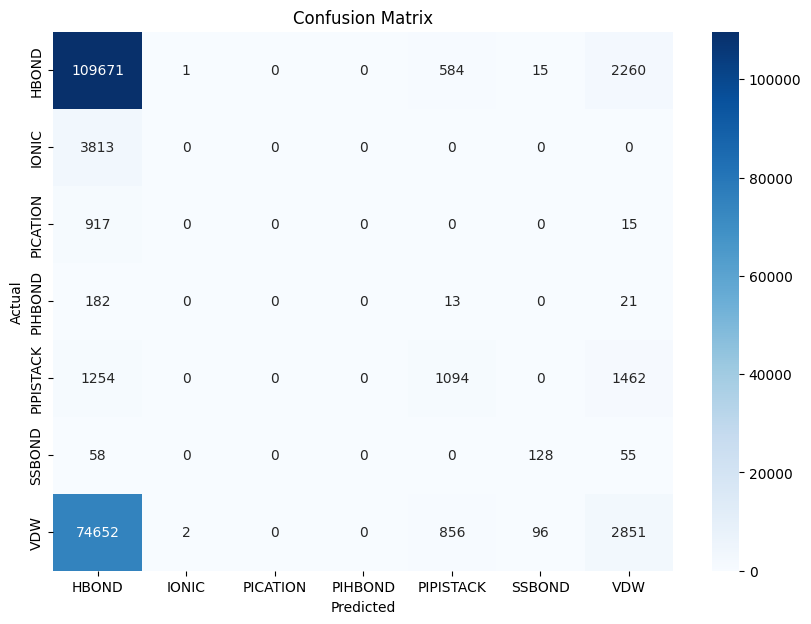

In [37]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_new_test, y_new_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

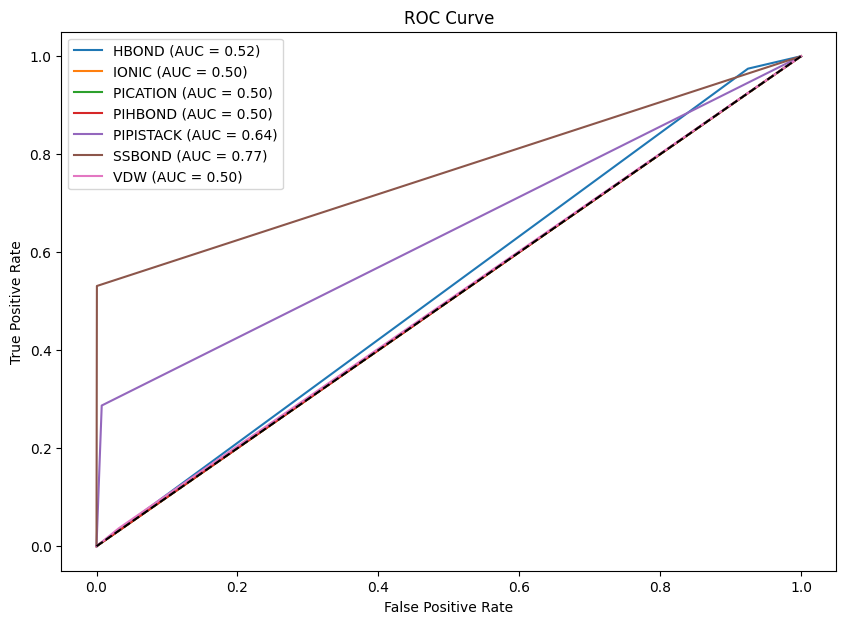

In [38]:
# ROC Curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC
y_test_binarized = label_binarize(y_new_test, classes=np.unique(y))
y_pred_binarized = label_binarize(y_new_pred, classes=np.unique(y))

plt.figure(figsize=(10, 7))
for i, label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
